#Instalar bibliotecas y paquetes

In [1]:
!pip install sentencepiece
!pip install transformers
!pip install pytorch-lightning
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.5 MB/s eta 0:00:00


#Importar modulos y bibliotecas

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl

from tqdm.auto import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from google.colab import drive
# mount your drive to colab where your dataset is present
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ruta al archivo TSV en tu Google Drive
file_path = '/content/drive/MyDrive/datasets/x-final/es/'


In [6]:
# Rutas de los archivos TSV
ruta_tsv_entrenamiento = '/content/drive/MyDrive/Datasets/x-final/es/translated_train.tsv'
ruta_tsv_test = '/content/drive/MyDrive/Datasets/x-final/es/test_2k.tsv'

# Leer los archivos TSV con pandas
datos_entrenamiento = pd.read_csv(ruta_tsv_entrenamiento, sep='\t')
datos_test = pd.read_csv(ruta_tsv_test, sep='\t')

# Rutas para guardar los archivos CSV
ruta_csv_entrenamiento = '/content/drive/MyDrive/Datasets/x-final/es/translated_train.csv'
ruta_csv_test = '/content/drive/MyDrive/Datasets/x-final/es/test_2k.csv'

# Guardar los datos en formato CSV
datos_entrenamiento.to_csv(ruta_csv_entrenamiento, index=False)
datos_test.to_csv(ruta_csv_test, index=False)

In [7]:
datos_entrenamiento.head()

,id,sentence1,sentence2,label
0,1,"En París, en octubre de 1560, se reunió en sec...","En octubre de 1560, se reunió en secreto con e...",0
1,2,La temporada de la NBA de 1975: 76 fue la 30ª ...,La temporada 1975 - 76 de la Asociación Nacion...,1
2,3,"También hay discusiones específicas, debates d...","También hay discusiones públicas, discusiones ...",0
3,4,Cuando se pueden mantener tasas de flujo compa...,Los resultados son altos cuando se pueden mant...,1
4,5,Es la sede del distrito de Zerendi en la regió...,Es la sede del distrito de Zerendi en la regió...,1


In [8]:
datos_test.head()

,id,sentence1,sentence2,label
0,10,La excepción fue entre fines de 2005 y 2009 cu...,La excepción se dio entre fines del 2005 y 200...,1
1,12,El río Tabaci es una vertiente del río Leurda ...,El río Leurda es un afluente del río Tabaci en...,0
2,20,Jugó con los Kane County Cougars clase A en 19...,Jugó en 1993 con Portland Sea Dogs clase A y K...,0
3,26,"Winarsky es miembro de IEEE, Phi Beta Kappa, A...","Winarsky es miembro de ACM, IEEE, Phi Beta Kap...",1
4,27,En 1938 se convirtió en el antropólogo del gob...,En 1938 se convirtió en antropólogo del gobier...,0


In [9]:
datos_entrenamiento.shape, datos_test.shape

((49401, 4), (2000, 4))

#Cargando el modelo pre entrenado PEGASUS

In [10]:
model_name = 'google/pegasus-large'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [45]:
#Inicialización de listas para almacenar la cantidad de tokens en las oraciones
sentence1_token_counts, sentence2_token_counts = [], []

# Iteración sobre los datos de entrenamiento
for _, row in datos_entrenamiento.iterrows():
    # Verificar si hay valores nulos en sentence1 y sentence2
    if pd.notna(row["sentence1"]) and pd.notna(row["sentence2"]):
        # Tokenización de las oraciones sentence1
        sentence1_tokens = tokenizer.encode(row["sentence1"], truncation=True, max_length=512)
        sentence1_token_count = len(sentence1_tokens)
        sentence1_token_counts.append(sentence1_token_count)

        # Tokenización de las oraciones sentence2
        sentence2_tokens = tokenizer.encode(row["sentence2"], truncation=True, max_length=512)
        sentence2_token_count = len(sentence2_tokens)
        sentence2_token_counts.append(sentence2_token_count)
    else:
        # manejar los valores nulos de alguna manera, como ignorar el registro o asignar un valor predeterminado
        print(f"Saltar fila con valores NaN en la oración 1 o la oración 2, ID: {row['id']}")


Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 306
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 473
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 624
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 1209
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 1698
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 1858
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 1975
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 2325
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 2530
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 2739
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 2912
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 2991
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 3046
Saltar fila con valores NaN en la oración 1 o la oración 2, ID: 3135
Saltar fila con valores NaN en la ora

In [14]:
# Encontrar la longitud maxima de las cadenas
datos_entrenamiento["sentence1"].str.len().max(), datos_entrenamiento["sentence2"].str.len().max()

(259.0, 267.0)

Text(0.5, 1.0, 'sentence2 recuento de tokens')

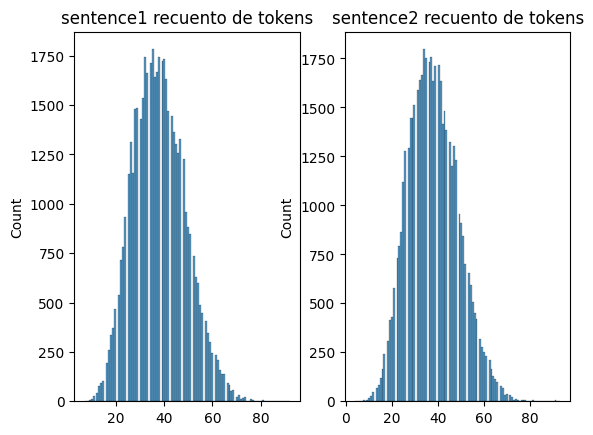

In [47]:
# conteo de tokens en las oraciones
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(sentence1_token_counts, ax=ax1)
ax1.set_title("sentence1 recuento de tokens")

sns.histplot(sentence2_token_counts, ax=ax2)
ax2.set_title("sentence2 recuento de tokens")

In [20]:
example =datos_entrenamiento.iloc[1]["sentence1"]
example

'La temporada de la NBA de 1975: 76 fue la 30ª temporada de la National Basketball Association.'

In [21]:
example2 = datos_entrenamiento.iloc[1]["sentence2"]
example2

'La temporada 1975 - 76 de la Asociación Nacional de Baloncesto fue la temporada 30 de la NBA.'

In [22]:
example3 = datos_entrenamiento.iloc[1]["label"]
example3

1

In [23]:
tokenizer.tokenize(example)

['▁La',
 '▁tempo',
 'rada',
 '▁de',
 '▁la',
 '▁NBA',
 '▁de',
 '▁1975',
 ':',
 '▁76',
 '▁fu',
 'e',
 '▁la',
 '▁30',
 'a',
 '▁tempo',
 'rada',
 '▁de',
 '▁la',
 '▁National',
 '▁Basketball',
 '▁Association',
 '.']

In [24]:
tokenizer.encode(example)

[1946,
 18733,
 30441,
 718,
 3119,
 7766,
 718,
 17918,
 151,
 9871,
 22204,
 326,
 3119,
 677,
 304,
 18733,
 30441,
 718,
 3119,
 765,
 13427,
 1534,
 107,
 1]

In [25]:
class PAWXDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sentence1 = item["sentence1"]
        sentence2 = item["sentence2"]
        label = item["label"]

        encoding = self.tokenizer(
            sentence1,
            sentence2,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "id": item["id"],
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [26]:
class PAWXDataModule:

    def __init__(
        self,
        train_path: str,
        test_path: str,
        tokenizer: PegasusTokenizer,
        batch_size: int = 2,
        sentence1_max_token_len: int = 512,
        sentence2_max_token_len: int = 512
    ):

        self.train_path = train_path
        self.test_path = test_path

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.sentence1_max_token_len = sentence1_max_token_len
        self.sentence2_max_token_len = sentence2_max_token_len

    def setup(self, stage=None):
        self.train_dataset = PAWXDataset(
            pd.read_csv(self.train_path),
            self.tokenizer,
            self.sentence1_max_token_len,
            self.sentence2_max_token_len
        )

        self.test_dataset = PAWXDataset(
            pd.read_csv(self.test_path),
            self.tokenizer,
            self.sentence1_max_token_len,
            self.sentence2_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )


In [29]:
N_EPOCHS = 3
BATCH_SIZE = 2

# Suponiendo que tienes las rutas de tus conjuntos de datos PAWS-X
train_path = "/content/drive/MyDrive/Datasets/x-final/es/translated_train.tsv"
test_path = "/content/drive/MyDrive/Datasets/x-final/es/test_2k.tsv"

# Crear la instancia de PAWXDataModule
data_module = PAWXDataModule(train_path, test_path, tokenizer, batch_size=BATCH_SIZE)


In [35]:
class PAWXModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large", return_dict=True)

    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

# Función de entrenamiento
def train_step(model, batch, optimizer):
    model.train()
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    optimizer.zero_grad()
    loss, _ = model(input_ids, attention_mask, labels=labels)
    loss.backward()
    optimizer.step()

    return loss.item()

# Función de prueba
def test_step(model, batch):
    model.eval()
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    with torch.no_grad():
        loss, _ = model(input_ids, attention_mask, labels=labels)

    return loss.item()

# Función de configuración de optimizadores
def configure_optimizers(model):
    return torch.optim.Adam(model.parameters(), lr=0.0001)

In [36]:
model = PAWXModel()

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Configuración de ModelCheckpoint y TensorBoardLogger
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="pawx-model")

# Crear una instancia de PAWXDataModule con las rutas de tus conjuntos de datos
data_module = PAWXDataModule(train_path, test_path, tokenizer, batch_size=BATCH_SIZE)

# Configuración del entrenador de PyTorch Lightning
trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    accelerator="auto"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [44]:
# Entrenar el modelo
trainer.fit(model, data_module.train_dataloader())

AttributeError: ignored